In [1]:
# 기본 설정
SAMPLES_PER_CLASS = 100
TRADITIONAL_AUGMENTS = 2  # 각 이미지당 2개

# LoRA 설정
LORA_RANK = 8
LORA_STEPS = 1000
LORA_BATCH_SIZE = 1
LORA_LR = 1e-4

# SD 생성 설정
SD_IMAGES_PER_CLASS = 200
SD_STRENGTH = 0.5
SD_STEPS = 30
SD_GUIDANCE = 7.0

# 분류기 설정
CLASSIFIER_EPOCHS = 100
CLASSIFIER_BATCH_SIZE = 128
CLASSIFIER_LR = 0.05

# 디바이스
DEVICE = 'cuda'

print("device : " + DEVICE)
print("설정 완료")

import warnings
warnings.filterwarnings('ignore')

device : cuda
설정 완료


In [2]:
from data import get_few_shot_cifar10, CLASS_NAMES

train_subset, test_subset = get_few_shot_cifar10(
    samples_per_class=SAMPLES_PER_CLASS
)

print(f"\n클래스: {CLASS_NAMES}")
print(f"Train 샘플: {len(train_subset)}")
print(f"Test 샘플: {len(test_subset)}")

Train: 1000 images (100 per class)
Test: 10000 images

클래스: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train 샘플: 1000
Test 샘플: 10000


In [ ]:
import matplotlib.pyplot as plt
from data import CLASS_NAMES, get_image_and_label

# airplane 클래스 샘플 확인
target_class = 0
class_name = CLASS_NAMES[target_class]

# 해당 클래스 이미지 찾기
samples = []
for idx in range(len(train_subset)):
    img, label = get_image_and_label(train_subset, idx)  # 이미 PIL로 변환
    if label == target_class and len(samples) < 5:
        samples.append(img)
    if len(samples) >= 5:
        break

# 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img in zip(axes, samples):
    ax.imshow(img)
    ax.axis('off')
plt.suptitle(f'Original CIFAR-10 Samples ({class_name})')
plt.tight_layout()
plt.show()

In [3]:
from augment_traditional import generate_traditional_augmentations
from pathlib import Path

traditional_aug_dir = Path('./data/aug_traditional')

# 이미 생성되어 있으면 건너뛰기
if traditional_aug_dir.exists() and len(list(traditional_aug_dir.glob('*/*.png'))) > 0:
    print("전통적 증강 이미 존재. SKIP")
else:
    generate_traditional_augmentations(
        dataset=train_subset,
        augments_per_image=TRADITIONAL_AUGMENTS,
        output_dir=traditional_aug_dir
    )

print(f"\n저장 위치: {traditional_aug_dir}")

전통적 증강 이미 존재. SKIP

저장 위치: data/aug_traditional


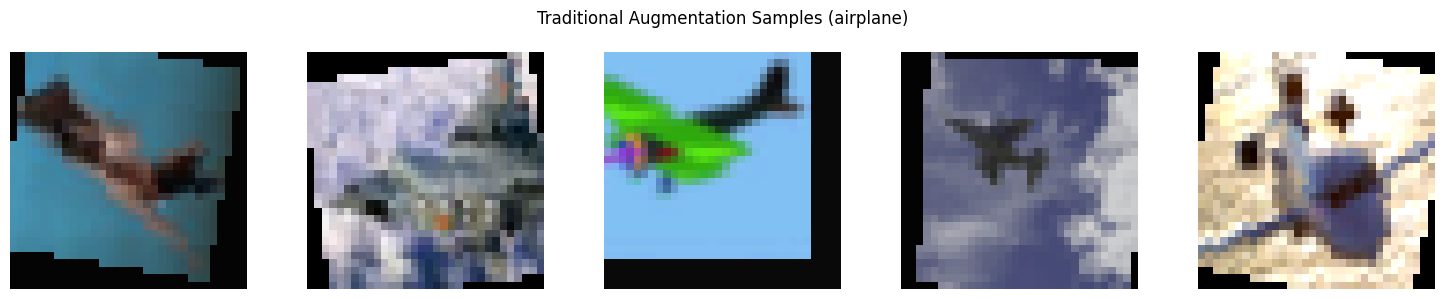

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# airplane 클래스 샘플 확인
class_dir = traditional_aug_dir / 'airplane'
samples = list(class_dir.glob('*.png'))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, samples):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Traditional Augmentation Samples (airplane)')
plt.tight_layout()
plt.show()

In [6]:
from train_lora import train_lora

lora_path = Path('./models/lora/lora_weights.safetensors')

# 이미 학습되어 있으면 건너뛰기
if lora_path.exists():
    print(f"LoRA 가중치 존재: {lora_path}")
    print("SKIP. (재학습하려면 파일 삭제 후 실행)")
else:
    train_lora(
        original_dataset=train_subset,
        aug_dir=traditional_aug_dir,
        rank=LORA_RANK,
        steps=LORA_STEPS,
        batch_size=LORA_BATCH_SIZE,
        lr=LORA_LR,
        device=DEVICE
    )

LoRA 가중치 존재: models/lora/lora_weights.safetensors
SKIP. (재학습하려면 파일 삭제 후 실행)


In [7]:
from generate_sd import generate_sd_augmentations

sd_aug_dir = Path('./data/aug_sd')

# 이미 생성되어 있으면 건너뛰기
if sd_aug_dir.exists() and len(list(sd_aug_dir.glob('*/*.png'))) >= SD_IMAGES_PER_CLASS * 10:
    print("SD 증강 이미지 이미 존재. SKIP.")
else:
    generate_sd_augmentations(
        original_dataset=train_subset,
        lora_path=lora_path,
        output_dir=sd_aug_dir,
        images_per_class=SD_IMAGES_PER_CLASS,
        strength=SD_STRENGTH,
        steps=SD_STEPS,
        guidance=SD_GUIDANCE,
        device=DEVICE
    )

print(f"\n저장 위치: {sd_aug_dir}")

SD 증강 이미지 이미 존재. SKIP.

저장 위치: data/aug_sd


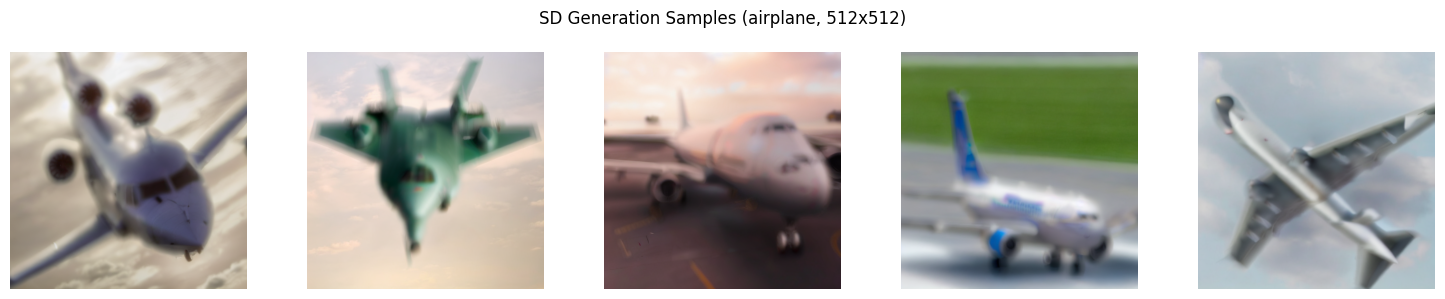

In [8]:
# SD 생성 샘플 확인
class_dir = sd_aug_dir / 'airplane'
samples = list(class_dir.glob('*.png'))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, samples):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('SD Generation Samples (airplane, 512x512)')
plt.tight_layout()
plt.show()

In [9]:
from generate_sd import downsample_to_32x32

sd_aug_32_dir = Path('./data/aug_sd_32')

if sd_aug_32_dir.exists() and len(list(sd_aug_32_dir.glob('*/*.png'))) > 0:
    print("32x32 이미지 이미 존재. SKIP.")
else:
    downsample_to_32x32(
        input_dir=sd_aug_dir,
        output_dir=sd_aug_32_dir
    )

print(f"\n저장 위치: {sd_aug_32_dir}")

32x32 이미지 이미 존재. SKIP.

저장 위치: data/aug_sd_32


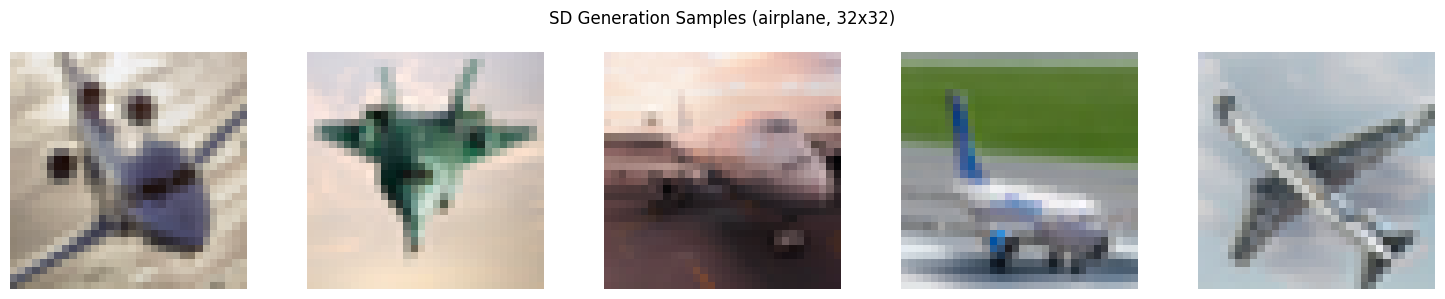

In [10]:
# SD 32*32 downsampling 샘플 확인
class_dir = sd_aug_32_dir / 'airplane'
samples = list(class_dir.glob('*.png'))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, samples):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('SD Generation Samples (airplane, 32x32)')
plt.tight_layout()
plt.show()

In [11]:
from train_classifier import run_experiments
from resnet import get_resnet18_cifar10

results = run_experiments(
    original_dataset=train_subset,
    test_dataset=test_subset,
    model_fn=get_resnet18_cifar10,
    traditional_aug_dir=traditional_aug_dir,
    sd_aug_dir=sd_aug_32_dir,
    output_dir='./results',
    epochs=CLASSIFIER_EPOCHS,
    batch_size=CLASSIFIER_BATCH_SIZE,
    lr=CLASSIFIER_LR
)


Experiment 1: Original only (100 images)
Dataset size: 1000
[010] train 0.2296/0.9370  test 2.3339/0.3791  best 0.3791
[020] train 0.0453/0.9940  test 3.0690/0.3637  best 0.3844
[030] train 0.0021/1.0000  test 3.0249/0.3836  best 0.3935
[040] train 0.0006/1.0000  test 2.8223/0.3969  best 0.3970
[050] train 0.0004/1.0000  test 2.7889/0.3988  best 0.3998
[060] train 0.0003/1.0000  test 2.7580/0.4021  best 0.4021
[070] train 0.0003/1.0000  test 2.7381/0.4009  best 0.4021
[080] train 0.0003/1.0000  test 2.7365/0.4009  best 0.4027
[090] train 0.0003/1.0000  test 2.7345/0.4013  best 0.4027
[100] train 0.0003/1.0000  test 2.7315/0.4009  best 0.4027

Experiment 2: Original + Traditional augmentation
Dataset size: 3000
[010] train 0.8147/0.7083  test 2.9207/0.3052  best 0.3494
[020] train 0.0376/0.9900  test 3.0568/0.4416  best 0.4416
[030] train 0.0007/1.0000  test 2.8090/0.4616  best 0.4616
[040] train 0.0005/1.0000  test 2.6598/0.4646  best 0.4646
[050] train 0.0006/1.0000  test 2.5632/0.46

최종 결과
                  train_size  best_acc  final_acc
exp5_hybrid           5000.0    0.4846     0.4773
exp2_traditional      3000.0    0.4706     0.4686
exp4_hybrid           3000.0    0.4471     0.4447
exp3_sd               3000.0    0.4334     0.4297
exp1_original         1000.0    0.4027     0.4009


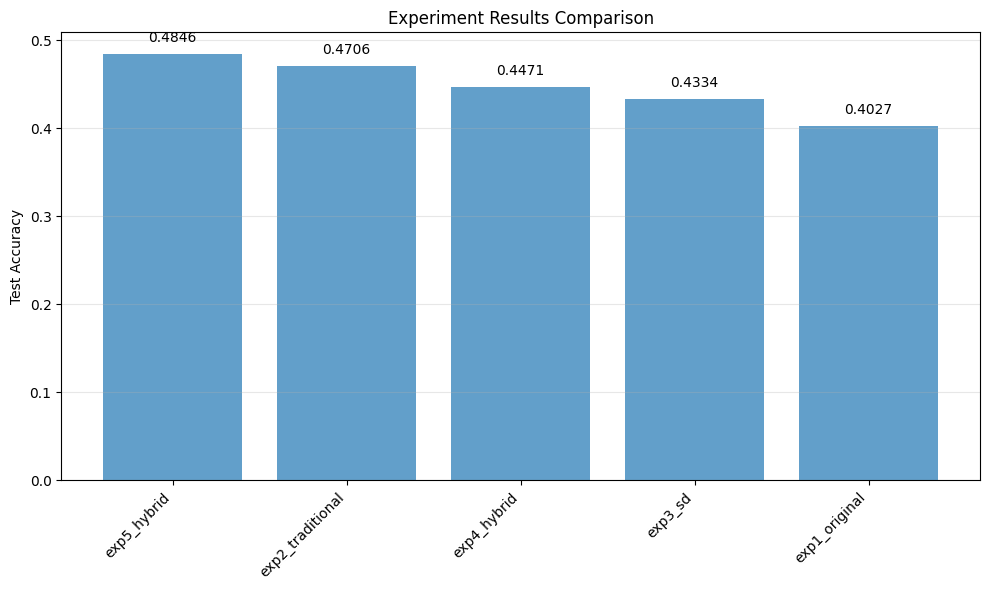


Baseline: 0.4027

향상도:
exp2_traditional    : +0.0679 (+16.86%)
exp3_sd             : +0.0307 (+7.62%)
exp4_hybrid         : +0.0444 (+11.03%)
exp5_hybrid         : +0.0819 (+20.34%)


In [12]:
import json
import pandas as pd

# 결과 로드
with open('./results/results.json') as f:
    results = json.load(f)

# DataFrame으로 변환
df = pd.DataFrame(results).T
df = df.sort_values('best_acc', ascending=False)


print("최종 결과")
print("=" * 70)
print(df[['train_size', 'best_acc', 'final_acc']])
print("=" * 70)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(df))
ax.bar(x, df['best_acc'], alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=45, ha='right')
ax.set_ylabel('Test Accuracy')
ax.set_title('Experiment Results Comparison')
ax.grid(axis='y', alpha=0.3)

# 정확도 값 표시
for i, (idx, row) in enumerate(df.iterrows()):
    ax.text(i, row['best_acc'] + 0.01, f"{row['best_acc']:.4f}", 
           ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 향상도 계산
baseline_acc = results['exp1_original']['best_acc']
print(f"\nBaseline: {baseline_acc:.4f}")
print("\n향상도:")
for name, result in results.items():
    if name != 'exp1_original':
        improvement = result['best_acc'] - baseline_acc
        print(f"{name:20s}: +{improvement:.4f} ({improvement/baseline_acc*100:+.2f}%)")